In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import numpy as np

from PIL import Image
from torchvision.transforms import v2

In [2]:
import dlib
import cv2

In [3]:
MODEL_PATH = Path("model/model_mercury_5_param_9000.pt")
LATENT_DIM = 256
IMG_SIZE = 256

torch.manual_seed(42)

def prep_tensor_to_show(tensor):
    return tensor.permute(1, 2, 0).detach().to('cpu').numpy()

def show_tensor_picture(tensor, title=""):
    im_arr = prep_tensor_to_show(tensor)
    plt.title(title)
    plt.axis("off")
    plt.imshow((im_arr*255).astype(np.uint8))

def prep_image(filename)-> torch.tensor:
    image = Image.open(filename).convert("RGB")
    image_min_size = min(image.size)
    transforms = v2.Compose([
        v2.ToImage(),
        v2.CenterCrop(image_min_size),
        v2.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
        v2.ToDtype(torch.float32, scale=True)
    ])
    return transforms(image).cuda(0)

def plot_images(images, labels, nrows, ncols, step=1, title="", figsize=[8, 4]):
    """Plot nrows x ncols images from images and set labels as titles."""
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        idx = i * step
        if images[i].shape[-1] == 1:
            ax.imshow((255*images[i]).reshape(images[idx].shape[0], images[idx].shape[1]).astype(np.uint8))
        else:
            ax.imshow((255*images[idx]).astype(np.uint8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(labels[idx])
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()



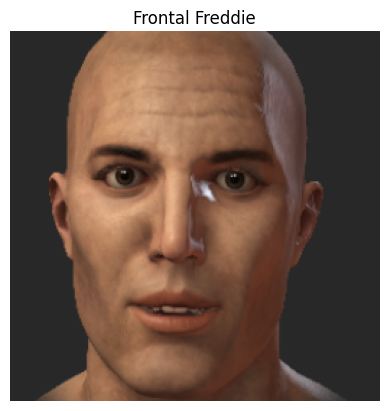

In [18]:
# MIDDLE_IMAGE_PATH = "img/from_dataset/middle_mercury.png"
# FREDDIE_INGAME_PATH = "img/from_dataset/perfect_mercury.png"
# FREDDIE_REAL_PATH = "img/real-freddies/1.jpg"

# middle_image = prep_image(MIDDLE_IMAGE_PATH)
# freddie_ingame = prep_image(FREDDIE_INGAME_PATH)
# freddie_real = prep_image(FREDDIE_REAL_PATH)

frontal_freddie_tensor = prep_image("img/mamaaaaaaaa.png")

show_tensor_picture(frontal_freddie_tensor, title="Frontal Freddie")

In [19]:
def get_landmarks(image: torch.tensor) -> torch.tensor:
    image = image.permute(1, 2, 0).cpu().numpy()
    image = image * 255
    image = image.astype(np.uint8)

    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

    UPSAMPLE = 1
    faces = detector(image, UPSAMPLE)
    if len(faces) == 0:
        raise ValueError("No faces detected")
    
    face = faces[0]
    landmarks = predictor(image, face)
    landmarks = np.array([[p.x, p.y] for p in landmarks.parts()]) 
    return torch.from_numpy(landmarks)
    
frontal_freddie_landmarks = get_landmarks(frontal_freddie_tensor)

frontal_freddie_landmarks.shape

torch.Size([68, 2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


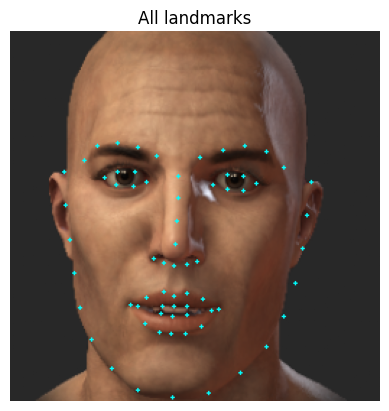

In [20]:
def show_landmarks(image, landmarks, title="Landmarks"):
    image = image.copy()
    for (x, y) in landmarks:
        cv2.circle(image, (x, y), 1, (0, 255, 255), -1)
    plt.title(title)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

image_with_landmarks = prep_tensor_to_show(frontal_freddie_tensor)
landmarks = frontal_freddie_landmarks.numpy()

show_landmarks(image_with_landmarks, landmarks, title="All landmarks")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


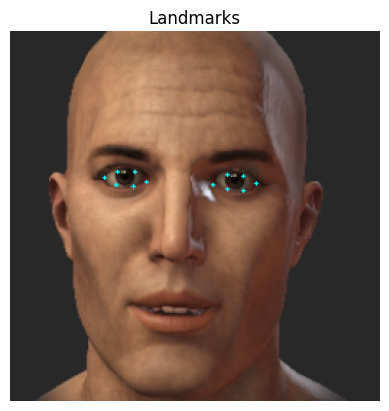

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


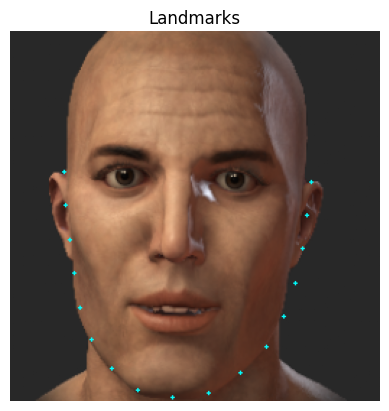

In [23]:
def jaw_landmarks(landmarks):
    return landmarks[0:17, :]

def eye_landmarks(landmarks):
    return landmarks[36:48, :]

image = prep_tensor_to_show(frontal_freddie_tensor)
freddie_jaw_lm = jaw_landmarks(frontal_freddie_landmarks).numpy()
freddie_eye_lm = eye_landmarks(frontal_freddie_landmarks).numpy()

show_landmarks(image, freddie_eye_lm)
show_landmarks(image, freddie_jaw_lm)

In [28]:
import numpy as np
def process_image(image, landmarks):
    # Get the coordinates of the left and right eye landmarks
    left_eye = landmarks[36:42]
    right_eye = landmarks[42:48]

    # Calculate the midpoint of the left and right eye landmarks
    left_eye_midpoint = np.mean(left_eye, axis=0)
    right_eye_midpoint = np.mean(right_eye, axis=0)

    # Calculate the desired midpoint (the middle of the image)
    desired_midpoint = np.array([image.shape[1] / 2, image.shape[0] / 2])

    # Calculate the translation vector
    translation_vector = desired_midpoint - (left_eye_midpoint + right_eye_midpoint) / 2

    # Translate the image and landmarks
    translated_image = v2.functional.affine(image, angle=0, translate=translation_vector, scale=1, shear=0)
    translated_landmarks = landmarks + torch.from_numpy(translation_vector)

    return translated_image, translated_landmarks

# Assuming you have the frontal_freddie_tensor and frontal_freddie_landmarks defined
translated_image, translated_landmarks = process_image(frontal_freddie_tensor.cpu().numpy(), frontal_freddie_landmarks.cpu().numpy())

# Display the translated image and landmarks
show_tensor_picture(translated_image, title="Translated Image")
show_landmarks(prep_tensor_to_show(translated_image), translated_landmarks.numpy(), title="Translated Landmarks")


TypeError: Functional F.affine supports inputs of type dict_keys([<class 'torchvision.tv_tensors._image.Image'>, <class 'torch.Tensor'>, <class 'PIL.Image.Image'>, <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>, <class 'torchvision.tv_tensors._mask.Mask'>, <class 'torchvision.tv_tensors._video.Video'>]), but got <class 'numpy.ndarray'> instead.